In [1]:
%matplotlib inline
%load_ext autoreload

<strong>Dependencies</strong>: MeshPy, PyVTK, trimesh

<strong>Useful links</strong>:
 - TetGen : http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual006.html
 - MeshPy : https://documen.tician.de/meshpy/tri-tet.html#meshpy.tet.MeshInfo.adjacent_elements
 - SRF BluePrint : http://i.cs.hku.hk/~wenping/allhex.pdf
 
 - http://math.stackexchange.com/questions/225246/explanation-about-frames-as-distinct-from-a-co-ordinate-system

## Generate Tetrahedral Mesh

In [4]:
import meshpy
from meshpy.tet import MeshInfo, build
import numpy as np
import trimesh

tri_mesh = trimesh.load_mesh('../data/icosphere.stl')

# Define MeshPy options!
opt = meshpy.tet.Options(switches='pq', edgesout=True, facesout=True, neighout=True)

mesh_info = MeshInfo()
mesh_info.set_points(tri_mesh.vertices)
# Convert face data from np.int64 to int...
faces = [list(map(lambda x: int(x), i)) for i in tri_mesh.faces]
mesh_info.set_facets(faces)
tet_mesh = build(mesh_info, opt, max_volume=10)

# Output tetrahedral mesh
tet_mesh.write_vtk("../data/test.vtk")

## Compute surface curvature

#### Some useful information

 - Internal tetrahedrons have 4 neighbors (one on each face) - the neighbor 4-tuple is the indices of the neighboring tets.

 - The first neighbor of tetrahedron 'i' is oppposite to the first corner of tetrahedron 'i', and so on.

 - An index of -1 indicates there is no neighbor.

In [5]:
surface_faces = []
for i, tet in enumerate(tet_mesh.elements):
    
    neighbors = list(tet_mesh.neighbors[i])
    # Try to get the vertex indices of boundary face.
    # TODO(aidan) This only looks at the first boundary face, consider case where a tet has multiple...
    if -1 in neighbors:
        non_surface_vtx = tet[neighbors.index(-1)]
        tet_cpy = tet.copy()
        tet_cpy.remove(non_surface_vtx)
        surface_faces.append(tet_cpy)


### Compute normals

In [10]:
# Compute normal
def compute_normal(face):
    return np.cross(np.array(tet_mesh.points[face[1]]) - np.array(tet_mesh.points[face[0]]),
                    np.array(tet_mesh.points[face[2]]) - np.array(tet_mesh.points[face[0]]))

def compute_avg(face):
    return (np.array(tet_mesh.points[face[0]])
          + np.array(tet_mesh.points[face[1]])
          + np.array(tet_mesh.points[face[2]])) / 3

face_normals = [compute_normal(face) for face in surface_faces]
face_center = [compute_avg(face) for face in surface_faces]

#### Visualize normals

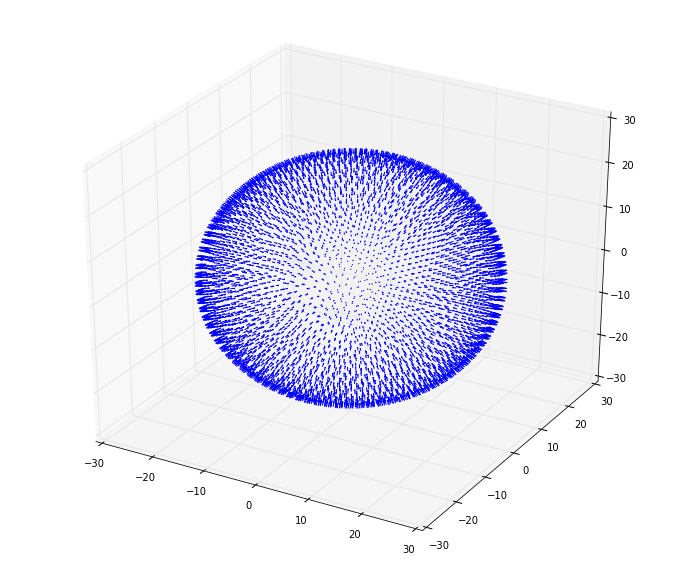

In [7]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i, f in enumerate(surface_faces):
    ax.quiver(face_center[i][0], face_center[i][1], face_center[i][2], face_normals[i][0], face_normals[i][1], face_normals[i][2])

plt.show()

### Compute neighbours

In [27]:
# Get neighbours
dedup_vertices = set(list(np.concatenate(surface_faces)))
surrounding_faces = {}
for i, v in enumerate(dedup_vertices):
    surrounding_faces[v] = list(filter(lambda f: f[0] == v or f[1] == v or f[2] == v, surface_faces))

### Vertex normal

In [28]:
from numpy import vstack

def v_norm(face):
    return vstack([face_normals[ind] for ind in f for f in faces]).mean(axis=0)

v_norms = {}
for i, v in enumerate(dedup_vertices):
    faces = surrounding_faces[v]
    v_norms[v] = v_norm(faces)